# **Lectura de Tickets - OCR**


**Objetivo**

En este cuaderno implementamos un flujo de OCR para tickets de gasto que convierte archivos PDF o imagen a texto y, posteriormente, extrae información clave (establecimiento, fecha, monto, lugar, moneda e ítems) con ayuda de un modelo de lenguaje. El enfoque prioriza robustez ante variabilidad de formatos y calidad de imagen, y sienta las bases para integrar este módulo al sistema de gestión de viáticos del Proyecto Integrador.

**Contexto y alcance**

En esta etapa se dio continuidad al análisis desarrollado en la fase anterior, enfocándose en la implementación de un flujo completo de lectura de tickets mediante Tesseract OCR. Se diseñaron y probaron funciones específicas para procesar 20 tickets pertenecientes a la categoría de Alimentación, seleccionando en particular los tickets de Walmart, debido a su alta variabilidad en brillo, contraste y calidad de impresión.

El objetivo de esta fase es evaluar la robustez del preprocesamiento frente a dichas variaciones, y posteriormente ajustar los parámetros de las operaciones morfológicas de OpenCV con el fin de generalizar el pipeline de lectura y mejorar la consistencia de los resultados del OCR ante diferentes condiciones visuales.

## **Instalación de Teseract**

Se instala el motor Tesseract con paquetes de idioma en inglés y español, además de pytesseract y pdf2image. Esto permite reconocer correctamente textos bilingües y convertir archivos PDF multipágina a imágenes de alta resolución.

In [282]:
# Install tesseract-ocr
!sudo apt update
!sudo apt install -y tesseract-ocr

# Install pytesseract and Pillow (for image handling)
!pip install pytesseract pillow

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 384 kB in 1s (397 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skip

In [283]:
!apt-get install poppler-utils -y
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.11).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [284]:
!sudo apt update
!sudo apt install tesseract-ocr tesseract-ocr-eng tesseract-ocr-spa

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as re

In [285]:
!pip install pymupdf

## **Librerias**

Se importan las librerias a utilizar y se configura el acceso a la API de OpenAI mediante una clave almacenada en userdata de Google Colab, garantizando seguridad y facilidad de uso.

In [286]:
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
from zipfile import ZipFile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import userdata
from openai import OpenAI
import openai
import json
import fitz  # pip install pymupdf
import pandas as pd
import time

In [287]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [288]:
api_key = userdata.get("miOpenAI_key")

if not api_key:
  raise ValueError("API key no encontrada en los secretos")

client = OpenAI(api_key=api_key)

## **Exportar Carpeta de Tickets**

Se exporta la carpeta (zip) para extraer todas las imagenes de tickets.

In [289]:
zip_path = '/content/drive/MyDrive/MNA/6to Trimestre/Proyecto Integrador/'

In [290]:
with ZipFile(zip_path + "Tickets_sin_anotaciones.zip", "r") as zip_ref:
    zip_ref.extractall("tickets")

## **Tabla con valores reales de los Tickets**

In [291]:
CSV_PATH = '/content/drive/MyDrive/MNA/6to Trimestre/Proyecto Integrador/Semana 7/Ticket_Walmart.csv'

In [421]:
# === Carga y limpieza básica ===
df = pd.read_csv(CSV_PATH)

In [422]:
df

,FileName,Establecimiento,MontoTotal,CantidadItems,Moneda,Estado_Ticket
0,869720_16.02.2025_Walmart.pdf,Walmart,48.27,4,USD,Buena
1,871084 Walmart.pdf,Walmart,35.25,12,USD,Mala
2,871306_05-03-25_Walmart.pdf,Walmart,29.91,6,USD,Media
3,872185 Walmart.pdf,Walmart,6.31,2,USD,Mala
4,872186 Walmart.pdf,Walmart,16.11,2,USD,Mala
5,872192 Walmart.pdf,Walmart,5.86,3,USD,Media
6,872198 - Ticket Walmart 05-03-25.pdf,Walmart,54.96,11,USD,Buena
7,872202 - Ticket Walmart 06-03-25.pdf,Walmart,37.64,12,USD,Buena
8,872205 - Ticket Walmart 07-03-25.pdf,Walmart,50.44,11,USD,Buena
9,872250 - Ticket Walmart 19-03-25.pdf,Walmart,16.17,1,USD,Buena


## **1. Lectura de Tickets**

### 1.1 Lectura de ticket "fotografiado"

#### 1.1.1 Lectura de ticket sin preprocesamiento

In [512]:
ticket1_p = '/content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf'

In [513]:
pages = convert_from_path(ticket1_p, dpi=400)
for i, page in enumerate(pages):
    filename = f"page_{i}.jpg"
    page.save(filename, 'JPEG')
    config = "--psm 6 --oem 1"
    text = pytesseract.image_to_string(Image.open(filename), lang='eng', config=config)
    print(f"--- Página {i+1} ---")
    print(text)

--- Página 1 ---
Give us feedback @ survey.walmart.com
Thank you! ID #: TVNBLOSCCHS |
wm §
Walmart 2,6.
WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD S
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR# 91021
# TTEMS SOLD 4
TC# 9067 7765 5992 4027 3911
ih. | AAW
\
I
Ni
MAGNETS CLIP 695780720191 3.97 X
MAGNETS CLIP 695780720191 3.97 X
12MM BLACK 012502595360 143:97:-X
12MM BLACK 012502595360 17.97 X
SUBTOTAL 43.38
TAX1 10.0000 % 4.39
TOTAL 43.27
| AMEX TEND 48.27
CHANGE DUE 0.00
AMERICAN EXPRESS- 1009 I 0 APPR#8S5970
43.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AID A000000025010801
TERMINAL # 28518783
*Pin Verified
02/16/25 21:51:03
O
at LI Get free delivery
ma “4 from this store
:” a a -
oR, a with Walmart+
Scan for 30-day free trial,
Low prices You Can Trust. Every Day.
O2/16/25 21:51:10



#### 1.1.2 Lectura de ticket con preprocesamiento

In [514]:
# Definir elemento estructurante
kernel = np.ones((5,5), np.uint8)

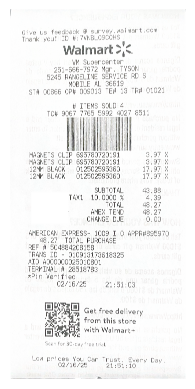

241.71202536186777


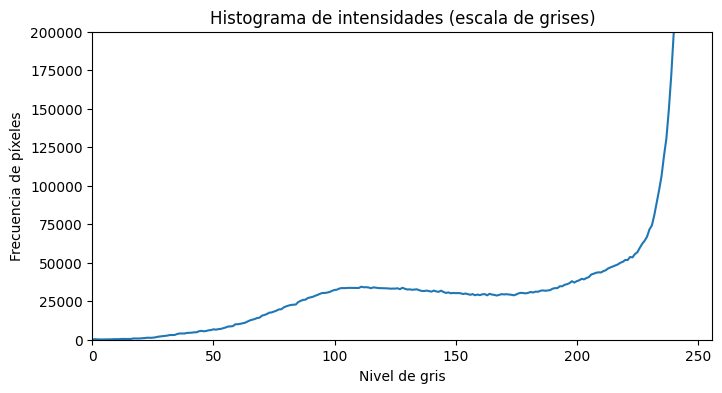

Closed

Give us feedback @ survey.waimart.coim
Thank you! ID #2 TVNBLOSCORS
WWAIIMArS 25%.
WM Supercenter
251-666-7972 Mor. TYSON
5045 RANGELINE SERVICE RD 5
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR 9102)
# ITEMS SOLD 4
TCs TMK HAHA
EPR TETIIH
| | : | Hl | \ |
a
ti i i nN tt | in "| Hi
MAGNETS CLIP 695780720191 3.97 K
MAGNETS CLIP 695780720191 3.97 K
12MM BLACK 012502599360 AT .S7 XK
12MM BLACK 012502595960 1/.97 K
SUBTOTAL 43.08 —
TAAL 10.0000 % 4.39
TOTAL A8 2]
: AMEX TEND G3 .2/
CHANGE DUE 0.00 |
AMERICAN EXPRESS- 1009 I OQ APPR#895970
46.27 TOTAL PURCHASE
REF # 304884208158
TRANS LD - 010913173618325
AID AQOOCO00025010801
TERMINAL # 28518783
“Pin Verified oo
02/16/25 (24:91:08
GI cate
Fae Get free delivery
Seite Ble rrom this store
lsgecee! with Walmart+
scar tor BO-dey free trial,
Low prices You Can Trust. Every Day.
02/16/25 21:51:10

Opened

Give us feedback @ survey.waimart.coim
Thank you! ID #2 TVNBLOSCORS
WWAIIMArS 25%.
WM Supercenter
251-666-7972 Mor. TYSON
5045 RANGE

In [515]:
# Leer la imagen
img = cv2.imread('/content/page_0.jpg')

# Mostrar
plt.imshow(img)
plt.axis('off')  # Oculta los ejes
plt.show()

# Escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contraste = cv2.convertScaleAbs(gray, alpha=0.9, beta=15)
gray = cv2.medianBlur(gray, 7)
# Calcular histograma
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)

# Binarización
thresh = cv2.adaptiveThreshold(gray, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 4)

#_, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
print(np.mean(gray))
# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)

# Opening
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Inv con Closing
inv = cv2.bitwise_not(thresh)
inv_closed = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel, iterations=1)
closed = cv2.bitwise_not(inv_closed)

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)
cv2.imwrite("ticket_opened.jpg", opened)
cv2.imwrite("ticket_closed.jpg", closed)

# Graficar
plt.figure(figsize=(8,4))
plt.title("Histograma de intensidades (escala de grises)")
plt.xlabel("Nivel de gris")
plt.ylabel("Frecuencia de píxeles")
plt.plot(hist)
plt.ylim([0, 200000])
plt.xlim([0, 256])
plt.show()

# Aplicar OCR
print("Closed\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_closed.jpg"), lang='eng', config=config)
print(text)

# Aplicar OCR
print("Opened\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_opened.jpg"), lang='eng', config=config)
print(text)

### 1.2 Lectura de ticket "escaneado"

#### 1.2.1 Lectura de ticket sin preprocesamiento

In [516]:
ticket1_p = '/content/tickets/Tickets/Walmart/872198 - Ticket Walmart 05-03-25.pdf'

In [517]:
pages = convert_from_path(ticket1_p, dpi=400)
for i, page in enumerate(pages):
    filename = f"page_{i}.jpg"
    page.save(filename, 'JPEG')
    config = "--psm 6 --oem 1"
    text = pytesseract.image_to_string(Image.open(filename), lang='eng', config=config)
    print(f"--- Página {i+1} ---")
    print(text)

--- Página 1 ---
Walma rt 7,4»:

Save money. Live better.

WAL* MART
TBD Mgr. TBD
5335 HIGHWAY 280
HOOVER, AL
ST# 2111 OP# 9001 TE# 1 TR# 535
WATERMELON 019434625184 F 7.97
SK LITE TUN 008000049525 F 2.74
SK LITE TUN 008000049525 F 2.74
MANGO 019434625164 F 4.317
ORG 7-SPROU 007347200101 F 7.453
MIX VEG 003470000060 F 2.67
MIX VEG 003470000060 F 2.67
CF COCONUT 085290900342 F 3.97
CALIFIA FAR 085290900330 F 3.97
BE ASIAN SF 001450002268 F 6.92
CHO YOGURT 089470001013 F 9,00
SUBTOTAL Swe
TAX 2 7 % 3.83
TOTAL 54.96
AMEX CREDIT TEND 54.96
AMEX RREKEK KREKRK KREREK 1000
CHANGE DUE 0.00
TC# 4647 7824 5559 4293 9769
03/05/25 20:11:09



#### 1.2.2 Lectura de ticket con preprocesamiento

In [518]:
# Definir elemento estructurante
kernel = np.ones((5,5), np.uint8)

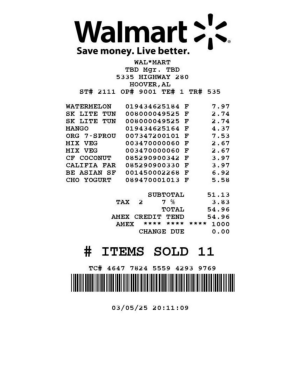

237.69857814171124


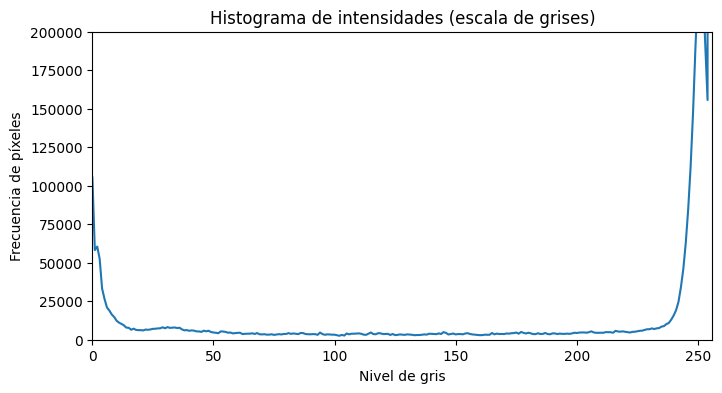

Closed

WalIManre 3,
Save money. Live better.
-WAL*MART _
TBD Mgr. TBD
5335 HIGHWAY 280
| HOOVER, AL |
ST# 2111 OP# 9001 TE# 1 TR#¥ 535
WATERMELON 019434625184 F 7.97
SK LITE TUN 008000049525 F 2.74
SK LITE TUN 008000049525 F 2.74
MANGO 019434625164 F 4.37
ORG 7-SPROU 007347200101 F 7.53
MIX VEG 003470000060 F 2.67
MIX VEG 003470000060 F 2.67
CF COCONUT 085290900342 F 3.97
CALIFIA FAR 085290900330 F 3.97
BE ASIAN SF 001450002268 F 6.92
CHO. YOGURT 089470001013 F 5.58
| SUBTOTAL 51.13
TAX 2 7 % 3.83
TOTAL 54.96
AMEX CREDIT TEND 54.96
AMEX kee kee KEE 1000
CHANGE DUE 0.00
TC# 4647 7824 5559 4293 9769
03/05/25 20:11:09

Opened

WalIManre 3,
Save money. Live better.
-WAL*MART _
TBD Mgr. TBD
5335 HIGHWAY 280
| HOOVER, AL |
ST# 2111 OP# 9001 TE# 1 TR#¥ 535
WATERMELON 019434625184 F 7.97
SK LITE TUN 008000049525 F 2.74
SK LITE TUN 008000049525 F 2.74
MANGO 019434625164 F 4.37
ORG 7-SPROU 007347200101 F 7.53
MIX VEG 003470000060 F 2.67
MIX VEG 003470000060 F 2.67
CF COCONUT 085290900342 F 3.9

In [519]:
# Leer la imagen
img = cv2.imread('/content/page_0.jpg')

# Mostrar
plt.imshow(img)
plt.axis('off')  # Oculta los ejes
plt.show()

# Escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contraste = cv2.convertScaleAbs(gray, alpha=0.9, beta=15)
gray = cv2.medianBlur(gray, 7)
# Calcular histograma
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)

# Binarización
thresh = cv2.adaptiveThreshold(gray, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 4)

#_, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
print(np.mean(gray))
# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)

# Opening
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Inv con Closing
inv = cv2.bitwise_not(thresh)
inv_closed = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel, iterations=1)
closed = cv2.bitwise_not(inv_closed)

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)
cv2.imwrite("ticket_opened.jpg", opened)
cv2.imwrite("ticket_closed.jpg", closed)

# Graficar
plt.figure(figsize=(8,4))
plt.title("Histograma de intensidades (escala de grises)")
plt.xlabel("Nivel de gris")
plt.ylabel("Frecuencia de píxeles")
plt.plot(hist)
plt.ylim([0, 200000])
plt.xlim([0, 256])
plt.show()

# Aplicar OCR
print("Closed\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_closed.jpg"), lang='eng', config=config)
print(text)

# Aplicar OCR
print("Opened\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_opened.jpg"), lang='eng', config=config)
print(text)

###

Durante las pruebas realizadas se observó una diferencia significativa entre los tickets escaneados y los tickets fotografiados, reflejada en la forma de sus histogramas de píxeles.

En los tickets escaneados, el histograma presenta picos pronunciados en los valores 0 y 255, indicando una imagen con alto contraste y un grado de binarización previo. En estos casos, aplicar nuevamente una etapa de binarización y otras transformaciones morfológicas puede deteriorar la imagen o provocar la pérdida de caracteres numéricos.

A partir de esta observación, se decidió implementar una función que evalúa la varianza de la imagen (o de su histograma) con el propósito de detectar automáticamente estas diferencias y omitir el preprocesamiento en aquellas imágenes que superen un umbral determinado (threshold), evitando así un procesamiento innecesario o contraproducente.

###1.3 Lectura de multiples tickets

In [298]:
tickets_direct_walmart = "/content/tickets/Tickets/Walmart/"
files_walmart = []
supported_extensions = ('.pdf', '.png', '.jpg', '.jpeg')

for root, _, files in os.walk(tickets_direct_walmart):
    for file in files:
        if file.lower().endswith(supported_extensions):
            files_walmart.append(os.path.join(root, file))
files_walmart.sort()


#### 1.3.1 Funciones

In [458]:
def necesita_preprocesamiento(gray):
    gray_norm = gray / 255.0
    var = gray_norm.var()
    print("Varianza:", var)
    return var < 0.035   # Umbral ajustable

Esta función `necesita_preprocesamiento` fue clave en la mejora del flujo de trabajo, ya que permitió distinguir automáticamente entre los tickets que requerían preprocesamiento y aquellos que no.
El umbral de decisión se ajustó empíricamente con base en las pruebas realizadas en las secciones 1.1 y 1.2, donde se analizó la varianza de los niveles de intensidad de distintos tipos de imágenes.

Gracias a este criterio, se logró optimizar el pipeline, evitando aplicar transformaciones innecesarias en tickets ya binarizados (como los escaneados) y enfocando los recursos de limpieza en aquellos con mayor variabilidad luminosa o presencia de ruido, típicos de las fotografías.
En conjunto, esta función aportó una mayor adaptabilidad y eficiencia al proceso de OCR, reduciendo errores de lectura y mejorando la calidad del texto extraído.

In [489]:
def preprocesar_imagen(img, aplicar_binarizado=True, aplicar_opening=False,
                       aplicar_closing=True, umbral=175, metodo_binarizado=cv2.THRESH_BINARY,
                       kernel_size=5, iteraciones=2):
    """
    Convierte la imagen a NumPy y aplica binarización + apertura morfológica opcional.
    Compatible con imágenes PIL o NumPy.
    """
    prep = False
    # Asegurar que sea NumPy array
    if isinstance(img, Image.Image):
        img_p = img.convert("RGB")   # Elimina canal alfa o paletas
        img_p = np.array(img_p)

    if not isinstance(img_p, np.ndarray):
        raise ValueError("La imagen no pudo convertirse a NumPy correctamente.")

    # Convertir a escala de grises
    if len(img_p.shape) == 3:
        gray = cv2.cvtColor(img_p, cv2.COLOR_RGB2GRAY)
        gray = cv2.medianBlur(gray, 7)
    else:
        gray = img_p.copy()

    if necesita_preprocesamiento(gray):
      print("Se preprocesa imagen")
      prep = True
      # Binarización
      if aplicar_binarizado:
        #_, img_out = cv2.threshold(gray, umbral, 255, metodo_binarizado)
        img_out = cv2.adaptiveThreshold(gray, 255,
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, 11, 4)

        # Opening solo si hay binarización
        if aplicar_opening:
          kernel = np.ones((kernel_size, kernel_size), np.uint8)
          img_out = cv2.morphologyEx(img_out, cv2.MORPH_OPEN, kernel, iterations=iteraciones)
        elif aplicar_closing:
          kernel = np.ones((kernel_size, kernel_size), np.uint8)
          img_out = cv2.morphologyEx(img_out, cv2.MORPH_OPEN, kernel, iterations=iteraciones)
    else:
      img_out=img

    return img_out, prep


Esta función constituye el **núcleo del pipeline de preprocesamiento**, combinando varias de las estrategias desarrolladas en etapas anteriores con nuevas mejoras implementadas en esta versión.
A diferencia de la entrega previa, aquí se integró la función necesita_preprocesamiento, lo que permitió **automatizar la decisión** sobre cuándo aplicar o no las operaciones de limpieza y binarización.
De esta forma, el proceso se adaptó dinámicamente a la calidad de cada ticket, evitando transformaciones innecesarias en imágenes ya limpias y mejorando la legibilidad en aquellas con ruido o baja iluminación.

Otra mejora clave fue la incorporación del **filtro de desenfoque (blur)** posterior a la conversión a escala de grises, que ayudó a estabilizar las variaciones de brillo y reducir artefactos antes de la binarización.
Además, se optó por utilizar un **umbral adaptativo (threshold adaptativo de tipo gaussiano)** en lugar de un umbral fijo, ya que este método **ajusta el valor de binarización según las condiciones locales de la imagen**, lo que resulta particularmente útil en fotografías con sombras o iluminación desigual.
Este cambio permitió **resaltar los caracteres relevantes sin perder detalle**, mejorando la precisión del OCR en casos donde el contraste del fondo no era uniforme.

En conjunto, esta versión de `preprocesar_imagen` refleja un avance importante respecto a la entrega anterior: el pipeline se vuelve **más robusto, flexible y eficiente,** capaz de adaptarse a distintas condiciones de captura sin perder precisión en la extracción de texto.

In [460]:
def extraer_textos_tickets(archivos_path, lang="eng", dpi=300, config = "--psm 6 --oem 1", limit = 5, preprocess=True):

    prep = False
    data = {}
    prep_df = pd.DataFrame(columns=["filename", "preprocesamiento"])
    processed = min(len(archivos_path), limit)
    print(f"\nSe encontraron {len(archivos_path)} tickets. Procesando {processed}\n")

    for i, archivo in enumerate(archivos_path):
        texto_total = ""
        if i >= limit:
          break
        try:
            # PDF
            if archivo.lower().endswith(".pdf"):
                pages = convert_from_path(archivo, dpi=dpi)
                for i, page in enumerate(pages):
                  if preprocess:
                    page_out, prep = preprocesar_imagen(page,
                                                  aplicar_binarizado=True)
                  else:
                    page_out = page
                  text = pytesseract.image_to_string(page_out,
                                                        lang=lang,
                                                        config=config)
                  texto_total += f"\n--- Página {i+1} ---\n{text}\n"

            # Imagen
            elif archivo.lower().endswith((".jpg", ".jpeg", ".png")):
                img = Image.open(archivo)
                if preprocess:
                  img_out, prep = preprocesar_imagen(img, aplicar_binarizado=True)
                else:
                  img_out = img
                texto_total = pytesseract.image_to_string(img_out,
                                                          lang=lang,
                                                          config=config)

            else:
                continue  # Ignora archivos no válidos

            print(f"Archivo procesado: {archivo}")
            data[archivo] = texto_total.strip()
            prep_df.loc[len(prep_df)] = [archivo, prep]

        except Exception as e:
            print(f"Error procesando {archivo}: {e}")

    return data, prep_df

Esta función constituye el bloque principal del flujo de lectura y extracción de texto, integrando de forma completa las etapas de preprocesamiento, conversión y OCR.
Su diseño permite procesar tanto archivos PDF (mediante la conversión de cada página en imagen) como imágenes individuales en formato JPG o PNG, adaptándose a los distintos tipos de tickets recopilados en el dataset.

Una mejora relevante de esta versión es la incorporación del preprocesamiento condicional, que depende del análisis de varianza implementado previamente.

Asimismo, la función registra en un DataFrame (prep_df) si cada ticket fue o no preprocesado, lo que facilita un análisis posterior del impacto del preprocesamiento sobre la calidad del OCR.
Esta trazabilidad es clave para evaluar cuantitativamente la eficacia de las etapas de mejora visual.

Finalmente, el uso de Tesseract con configuración personalizada (--psm 6 --oem 1) permite un balance adecuado entre precisión y velocidad, optimizando el reconocimiento de texto en documentos con estructura semirregular como los tickets.
En conjunto, esta función consolida un pipeline de extracción robusto, adaptable y escalable, capaz de manejar fuentes heterogéneas y mantener consistencia en los resultados.

In [461]:
def analizar_tickets(ocr_dict, model="gpt-4.1-mini", temperature=0.2):
    resultados = {}

    for filename, text in ocr_dict.items():
        prompt = f"""
Analiza el siguiente texto extraído de un ticket de compra.

Texto del ticket:
\"\"\"{text}\"\"\"

Extrae y devuelve los siguientes datos clave en formato JSON **completo**,
usando `null` o cadenas vacías ("") si algún dato no se encuentra en el texto.
No agregues explicaciones ni texto fuera del JSON.

Campos requeridos:
- establecimiento
- lugar
- monto_total
- cantidad_items
- items (lista con "nombre", "cantidad" y "precio")
- moneda

Ejemplo de salida esperada:
{{
  "establecimiento": "Walmart Supercenter",
  "lugar": "Mobile, AL",
  "monto_total": 48.27,
  "cantidad_items": 4,
  "items": [
    {{"nombre": "MAGNETS CLIP 695780720191", "cantidad": 2, "precio": 3.97}},
    {{"nombre": "12MM BLACK 01250295360", "cantidad": 2, "precio": 17.97}}
  ],
  "moneda": "USD"
}}
"""

        try:
            response = client.responses.create(
                model=model,
                input=prompt,
                temperature=temperature
            )

            text_output = response.output_text.strip()

            # Limpieza si el modelo devuelve bloque tipo ```json ... ```
            clean_output = text_output

            # Si empieza con ```
            if clean_output.startswith("```"):
                clean_output = clean_output.strip("`")  # elimina backticks del inicio y fin
                # elimina etiquetas "json" o "JSON" y saltos de línea extra
                clean_output = clean_output.replace("json", "").replace("JSON", "").strip()

            # Intentar convertir a JSON
            try:
                resultados[filename] = json.loads(clean_output)
            except json.JSONDecodeError:
                # Si sigue fallando, guardar texto original para depuración
                resultados[filename] = {"error": "Formato no válido", "texto_crudo": text_output}


        except Exception as e:
            resultados[filename] = {"error": str(e)}

    return resultados

Esta función se encarga de interpretar los textos extraídos por OCR mediante el uso de un modelo de lenguaje (en este caso, gpt-4.1-mini), con el objetivo de estructurar la información en formato JSON.
Su función principal es convertir texto libre en datos estructurados, identificando campos relevantes como el establecimiento, lugar, monto total, lista de ítems y moneda.

#### 1.3.2 Lectura Tickets Walmart

In [490]:
files_read, prep_df = extraer_textos_tickets(files_walmart, dpi=300, limit = 20, preprocess=True)


Se encontraron 74 tickets. Procesando 20

Varianza: 0.018837546946894733
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf
Varianza: 0.01767392656453692
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/871084 Walmart.pdf
Varianza: 0.012581902588301015
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/871306_05-03-25_Walmart.pdf
Varianza: 0.017831913605205574
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/872185 Walmart.pdf
Varianza: 0.024000350180033162
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/872186 Walmart.pdf
Varianza: 0.025552907898928234
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/872192 Walmart.pdf
Varianza: 0.047205339497502476
Archivo procesado: /content/tickets/Tickets/Walmart/872198 - Ticket Walmart 05-03-25.pdf
Varianza: 0.04857596342583872
Archivo procesado: /content/tickets/Tickets/Walmar

In [492]:
for nombre, texto in files_read.items():
    print(f"Ticket: {nombre}")
    print("Texto OCR:")
    print(texto)
    print("-" * 80)

Ticket: /content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf
Texto OCR:
--- Página 1 ---
Give us feedback @ survey.walmart.com
Thank you! ID H: TYNBLQQCOHS
al’ G
Walmaré 2,5.
| WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD s |
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR# 01021
# ITEMS SOLD 4 |
| C# th iio 9992 ie) Soll
| | A at a ith fl
ON ae
The CP
! 4 :
MAGNETS CLIP 695/780720191 . 3,97 Xk
MAGNETS CLIP 695780720191 | 3.97 K |
12MM BLACK 012502599360 17.97 X
12MM BLACK 012502595360 | 17.97 X
SUBTOTAL 43.88 |
TAXL 10.0000 % 4.39
TOTAL 43.2]
: AMEX TEND 43.2/
CHANGE DUE Q.00
AMERICAN EXPRESS- 1009 I 0 APPR#895970
~~ 48.27) =©6TOTAL PURCHASE | |
REF # 904884208158
TRANS ID - 010913173618325 |
AID AQ00000025010801
TERMINAL # 28518783 |
xPin Verified oo
02/16/25 (21:51:08
el all Get free delivery
ie >. cae from this store
ec aye with Walmart+
scan for 30-day free trial,
Low prices You Can Trust. Every Day.
02/16/25 _ 21:51:10 |
------------------------------

In [493]:
# Llamar la función
resultados = analizar_tickets(files_read)

# Mostrar resultados
for archivo, datos in resultados.items():
    print(f"\n📄 {archivo}")
    print(json.dumps(datos, indent=2, ensure_ascii=False))


📄 /content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf
{
  "establecimiento": "Walmart Supercenter",
  "lugar": "Mobile, AL",
  "monto_total": 43.28,
  "cantidad_items": 4,
  "items": [
    {
      "nombre": "MAGNETS CLIP 695780720191",
      "cantidad": 2,
      "precio": 3.97
    },
    {
      "nombre": "12MM BLACK 012502599360",
      "cantidad": 2,
      "precio": 17.97
    }
  ],
  "moneda": "USD"
}

📄 /content/tickets/Tickets/Walmart/871084 Walmart.pdf
{
  "establecimiento": "Walmart",
  "lugar": "",
  "monto_total": 2.29,
  "cantidad_items": null,
  "items": [],
  "moneda": "USD"
}

📄 /content/tickets/Tickets/Walmart/871306_05-03-25_Walmart.pdf
{
  "establecimiento": "Walmart Supercenter",
  "lugar": "Mobile, AL",
  "monto_total": 29.91,
  "cantidad_items": 6,
  "items": [
    {
      "nombre": "CHE FH PF 028400596690",
      "cantidad": 3,
      "precio": 3.33
    },
    {
      "nombre": "PROPEL 052000050220",
      "cantidad": 1,
      "precio": 4.37
    },
    {


## **2.0 Comparación**

In [494]:
comparacion = []

for ruta, ocr_data in resultados.items():
    nombre_archivo = os.path.basename(ruta)
    match = df[df["FileName"].str.contains(nombre_archivo.split()[0])]
    if not match.empty:
        row = match.iloc[0]
        comparacion.append({
            "FileName": nombre_archivo,
            "MontoTotal_OK": ocr_data["monto_total"] == row["MontoTotal"],
            "Items_OK": ocr_data["cantidad_items"] == row["CantidadItems"],
            "Moneda_OK": ocr_data["moneda"] == row["Moneda"]
        })

res_df = pd.DataFrame(comparacion)
res_df

,FileName,MontoTotal_OK,Items_OK,Moneda_OK
0,869720_16.02.2025_Walmart.pdf,False,True,True
1,871084 Walmart.pdf,False,False,True
2,871306_05-03-25_Walmart.pdf,True,True,True
3,872185 Walmart.pdf,True,True,True
4,872186 Walmart.pdf,True,True,True
5,872192 Walmart.pdf,True,True,True
6,872198 - Ticket Walmart 05-03-25.pdf,True,False,True
7,872202 - Ticket Walmart 06-03-25.pdf,True,True,True
8,872205 - Ticket Walmart 07-03-25.pdf,True,True,True
9,872250 - Ticket Walmart 19-03-25.pdf,True,True,True


In [495]:
porcentajes_columna = res_df[["MontoTotal_OK", "Items_OK", "Moneda_OK"]].mean() * 100
print(porcentajes_columna)

MontoTotal_OK     85.0
Items_OK          85.0
Moneda_OK        100.0
dtype: float64


En esta celda se calcularon los porcentajes de aciertos individuales para cada campo (MontoTotal_OK, Items_OK, Moneda_OK).
Los resultados muestran valores de 85 % en monto total y número de ítems, y 100 % en la detección de moneda, lo que indica que el modelo tiene un buen desempeño general, aunque aún presenta ligeras inconsistencias en la lectura de montos y conteo de artículos.

Estos errores suelen asociarse a variaciones en la calidad del texto OCR o diferencias en la estructura visual de los tickets, por lo que afinar los parámetros de binarización o mejorar el preprocesamiento podría elevar estos porcentajes.

In [496]:
todas_true = res_df[["MontoTotal_OK", "Items_OK", "Moneda_OK"]].all(axis=1)
porcentaje_todas_true = todas_true.mean() * 100
print(f"Porcentaje de registros con todas las columnas True: {porcentaje_todas_true:.2f}%")

Porcentaje de registros con todas las columnas True: 75.00%


Aquí se evaluó el porcentaje global de tickets correctamente extraídos en todas las variables clave, combinando los tres indicadores anteriores.
El resultado de 75 % de registros completamente correctos refleja un desempeño sólido del pipeline, considerando que se incluyeron imágenes con distintos niveles de calidad.

Este valor también evidencia que las estrategias de preprocesamiento y el umbral adaptativo están funcionando adecuadamente, aunque aún existe margen de mejora para reducir los casos en los que uno o más campos fallan en simultáneo.

In [497]:
merged = pd.merge(res_df, df[["FileName", "Estado_Ticket"]], on="FileName", how="left")
merged = pd.merge(merged, prep_df["preprocesamiento"], left_index=True, right_index=True, how="left")
merged["Todo_Ok"] = res_df[["MontoTotal_OK", "Items_OK", "Moneda_OK"]].all(axis=1)
merged

,FileName,MontoTotal_OK,Items_OK,Moneda_OK,Estado_Ticket,preprocesamiento,Todo_Ok
0,869720_16.02.2025_Walmart.pdf,False,True,True,Buena,True,False
1,871084 Walmart.pdf,False,False,True,Mala,True,False
2,871306_05-03-25_Walmart.pdf,True,True,True,Media,True,True
3,872185 Walmart.pdf,True,True,True,Mala,True,True
4,872186 Walmart.pdf,True,True,True,Mala,True,True
5,872192 Walmart.pdf,True,True,True,Media,True,True
6,872198 - Ticket Walmart 05-03-25.pdf,True,False,True,Buena,False,False
7,872202 - Ticket Walmart 06-03-25.pdf,True,True,True,Buena,False,True
8,872205 - Ticket Walmart 07-03-25.pdf,True,True,True,Buena,False,True
9,872250 - Ticket Walmart 19-03-25.pdf,True,True,True,Buena,False,True


En esta parte se realizó la integración de los resultados parciales (res_df, prep_df y df), incorporando también la columna Estado_Ticket, que clasifica la calidad visual de cada archivo.
El análisis permitió observar que los tickets con estado “Media” alcanzaron los porcentajes de acierto más altos (hasta 100 % en algunos campos), mientras que los tickets “Mala” muestran un desempeño más irregular.
Esto sugiere que el pipeline es robusto ante imágenes de calidad media, pero todavía puede fallar en casos con bajo contraste, sombras o texto distorsionado.


In [498]:
merged[merged["preprocesamiento"]]

,FileName,MontoTotal_OK,Items_OK,Moneda_OK,Estado_Ticket,preprocesamiento,Todo_Ok
0,869720_16.02.2025_Walmart.pdf,False,True,True,Buena,True,False
1,871084 Walmart.pdf,False,False,True,Mala,True,False
2,871306_05-03-25_Walmart.pdf,True,True,True,Media,True,True
3,872185 Walmart.pdf,True,True,True,Mala,True,True
4,872186 Walmart.pdf,True,True,True,Mala,True,True
5,872192 Walmart.pdf,True,True,True,Media,True,True
10,872543_25.03.2025_Walmart.pdf,True,True,True,Media,True,True
11,874471 - Ticket walmart ($USD204.39) 06-04-25 ...,True,True,True,Media,True,True
12,876034 - Ticket walmart($USD38.32) 28-04-25.pdf,True,True,True,Media,True,True
17,877184 - Ticket walmart ($USD185.93) 29-04-25.pdf,True,False,True,Media,True,False


In [499]:
cols_ok = ["MontoTotal_OK", "Items_OK", "Moneda_OK"]

porcentajes_por_estado = merged.groupby("Estado_Ticket")[cols_ok].mean() * 100

merged["Todo_OK"] = merged[cols_ok].all(axis=1)

porcentajes_por_estado["Todo_OK"] = (
    merged.groupby("Estado_Ticket")["Todo_OK"].mean() * 100
)

print(porcentajes_por_estado)

               MontoTotal_OK  Items_OK  Moneda_OK  Todo_OK
Estado_Ticket                                             
Buena                   75.0      87.5      100.0     62.5
Mala                    75.0      75.0      100.0     75.0
Media                  100.0      87.5      100.0     87.5


En esta última celda se agruparon los resultados por Estado_Ticket para analizar el desempeño relativo del OCR según la calidad visual.
Los valores promedio confirman la tendencia:

- Tickets “Buena”: 75–87 % de acierto total.

- Tickets “Media”: 87.5 % de acierto total.

- Tickets “Mala”: 75 % de acierto total.

A pesar de las diferencias, los resultados se mantienen consistentes y por encima del 70 % en todos los casos, lo que demuestra que el sistema logra mantener un desempeño estable incluso con imágenes de baja calidad.
Estos hallazgos respaldan la efectividad del preprocesamiento adaptativo y del umbral local (threshold adaptativo), los cuales contribuyeron a mejorar la lectura en escenarios con iluminación irregular.

## **3. Conclusiones**

Los resultados obtenidos muestran un desempeño general sólido, con porcentajes de acierto superiores al 75 % incluso en tickets de calidad media o baja.
Al revisar los textos extraídos por el OCR, se observó que los errores son mínimos y principalmente atribuibles a detalles menores de formato o reconocimiento parcial de caracteres, sin comprometer la comprensión general de los datos.

Esto confirma que el pipeline actual cumple adecuadamente con los objetivos de esta fase, demostrando su viabilidad técnica para automatizar la lectura de tickets con diferentes niveles de calidad.
Sin embargo, en etapas posteriores se prevé profundizar en el ajuste de los parámetros de preprocesamiento de imagen —como los tamaños de kernel, tipos de umbral o valores de desenfoque— con el fin de optimizar la nitidez y mejorar aún más la legibilidad de los caracteres.
Asimismo, será necesario evaluar el desempeño sobre un conjunto más amplio y variado de imágenes, que incluya diferentes formatos, condiciones de iluminación y artefactos de impresión, para consolidar la robustez del modelo.

Finalmente, se considera pertinente incorporar una etapa de limpieza adicional mediante expresiones regulares (regex) antes de enviar el texto al modelo de OpenAI.
Esto permitiría corregir errores residuales en montos, fechas o símbolos, mejorando la consistencia del parseo y potenciando la precisión del sistema en fases futuras del proyecto.